# Goingdeeper04
## unet++모델을 직접만들어 도로영역을 감지해보자.
### 필요한 라이브러리 가져오기

In [9]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *



### 데이터 준비

In [10]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    
                    ])
            
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

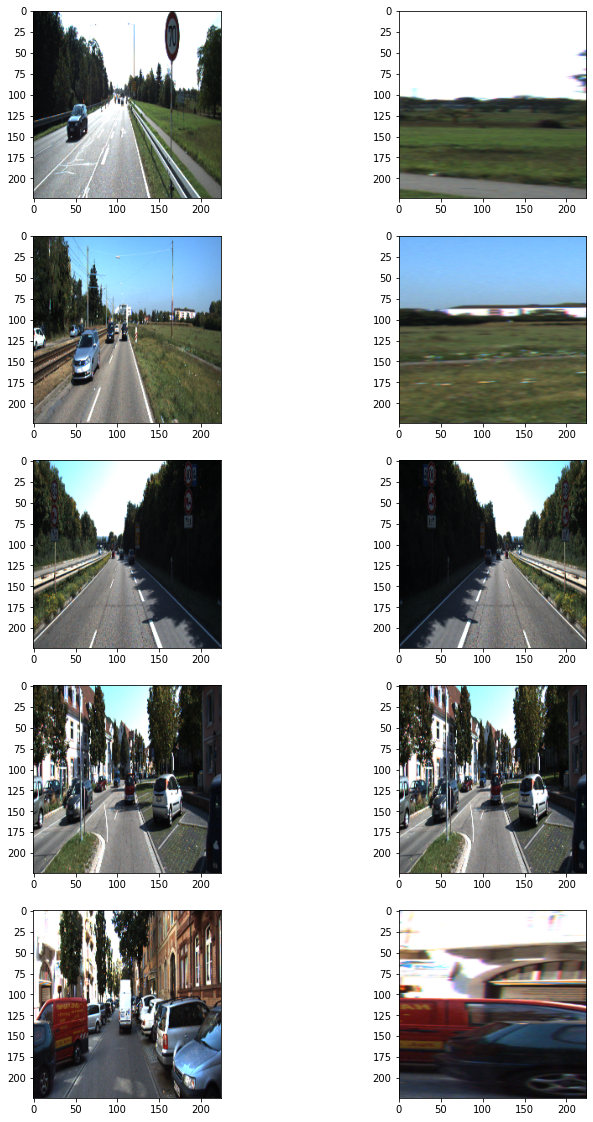

In [11]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [12]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=8,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [13]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

### 모델생성

In [6]:
def one_layers(b00,up10,up11,up12):
    merge01 = concatenate([b00,up10], axis = 3)
    x01 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge01)
    b01 = BatchNormalization()(x01)
    x01 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(b01)
    b01 = BatchNormalization()(x01)
  
    merge02 = concatenate([b00,b01,up11], axis = 3)
    x02 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge02)
    b02 = BatchNormalization()(x02)
    x02 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(b02)
    b02 = BatchNormalization()(x02)

    merge03 = concatenate([b00,b02,up12], axis = 3)
    x03 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge03)
    b03 = BatchNormalization()(x03)
    x03 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(b03)
    b03 = BatchNormalization()(x03)
    return b01, b02, b03

In [7]:
def two_layers(b10,up20,up21):
    merge11 = concatenate([b10,up20], axis = 3)
    x11 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge11)
    b11 = BatchNormalization()(x11)
    x11 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(b11)
    b11 = BatchNormalization()(x11)
    up11 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(b11)
  
    merge12 = concatenate([b10,b11,up21], axis = 3)
    x12 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge12)
    b12 = BatchNormalization()(x12)
    x12 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(b12)
    b12 = BatchNormalization()(x12)
    up12 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(b12)
    return b11, b12, up11, up12

In [8]:
def three_layers(b20,up30):
    merge21 = concatenate([b20,up30], axis = 3)
    x21 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge21)
    b21 = BatchNormalization()(x21)
    x21 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(b21)
    b21 = BatchNormalization()(x21)
    up21 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(b21)
    return b21, up21

In [9]:
def build_model(input_shape=(224, 224, 3)):
  inputs = Input(input_shape)
	
  #Contracting Path
  x00 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  b00 = BatchNormalization()(x00)
  x00 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(b00)
  b00 = BatchNormalization()(x00)
  p00 = MaxPooling2D(pool_size=(2, 2))(b00)
  
  
  x10 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(p00)
  b10 = BatchNormalization()(x10)
  x10 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(b10)
  b10 = BatchNormalization()(x10)
  up10 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(b10)
  p10 = MaxPooling2D(pool_size=(2, 2))(b10)
    
  x20 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(p10)
  b20 = BatchNormalization()(x20)
  x20 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(b20)
  b20 = BatchNormalization()(x20)
  up20 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(b20)
  p20 = MaxPooling2D(pool_size=(2, 2))(b20)

  x30 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(p20)
  b30 = BatchNormalization()(x30)
  x30 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(b30)
  b30 = BatchNormalization()(x30)
  up30 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(b30)
  drop30 = Dropout(0.5)(b30)
  p30 = MaxPooling2D(pool_size=(2, 2))(drop30)
##########################################################################################################
  b21,up21 = three_layers(b20,up30)
  b11,b12,up11,up12 = two_layers(b10,up20,up21)
  b01,b02,b03 = one_layers(b00,up10,up11,up12)
########################################################################################################
  
  
  x40 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(p30)
  b40 = BatchNormalization()(x40)
  x40 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(b40)
  b40 = BatchNormalization()(x40) 
  drop40 = Dropout(0.5)(b40)
  up40 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop40)
    
  merge31 = concatenate([drop30,up40], axis = 3)
  x31 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge31)
  b31 = BatchNormalization()(x31)
  x31 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(b31)
  b31 = BatchNormalization()(x31) 
  up31 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(b31)
    
  merge22 = concatenate([b20,up31,b21], axis = 3)
  x22 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge22)
  b22 = BatchNormalization()(x22) 
  x22 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(b22)
  b22 = BatchNormalization()(x22) 
  up22 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(b22)
    
  merge13 = concatenate([b10,up22,b12,b11], axis = 3)
  x13 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge13)
  b13 = BatchNormalization()(x13) 
  x13 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(b13)
  b13 = BatchNormalization()(x13) 
  up13 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(b13)
    
  merge04 = concatenate([b00,up13,b01,b02,b03], axis = 3)
  x04 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge04)
  b04 = BatchNormalization()(x04) 
  x04 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(b04)
  b04 = BatchNormalization()(x04) 
  x04 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(b04)     
  conv10 = Conv2D(1, 1, activation='sigmoid')(x04)

  #
  
  model = Model(inputs = inputs, outputs = conv10)
  return model

### unet++모델학습

In [10]:
from keras import backend as K

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [11]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

model = build_model()
model.compile(optimizer = Adam(1e-4), loss = bce_dice_loss)
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100
    
    
    
    ,
 )

model.save(model_path)

Epoch 1/100
22/22 [==============================] - 45s 1s/step - loss: 0.4238 - val_loss: 0.2977
Epoch 2/100
22/22 [==============================] - 22s 982ms/step - loss: 0.3005 - val_loss: 0.3018
Epoch 3/100
22/22 [==============================] - 21s 973ms/step - loss: 0.2930 - val_loss: 0.3006
Epoch 4/100
22/22 [==============================] - 22s 982ms/step - loss: 0.3024 - val_loss: 0.2850
Epoch 5/100
22/22 [==============================] - 22s 986ms/step - loss: 0.2822 - val_loss: 0.2836
Epoch 6/100
22/22 [==============================] - 22s 981ms/step - loss: 0.2548 - val_loss: 0.2682
Epoch 7/100
22/22 [==============================] - 22s 978ms/step - loss: 0.2673 - val_loss: 0.2560
Epoch 8/100
22/22 [==============================] - 22s 980ms/step - loss: 0.2518 - val_loss: 0.2810
Epoch 9/100
22/22 [==============================] - 22s 982ms/step - loss: 0.2609 - val_loss: 0.2788
Epoch 10/100
22/22 [==============================] - 22s 982ms/step - loss: 0.2702 -

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       batch_normalization[0][0]        
______________________________________________________________________________________________

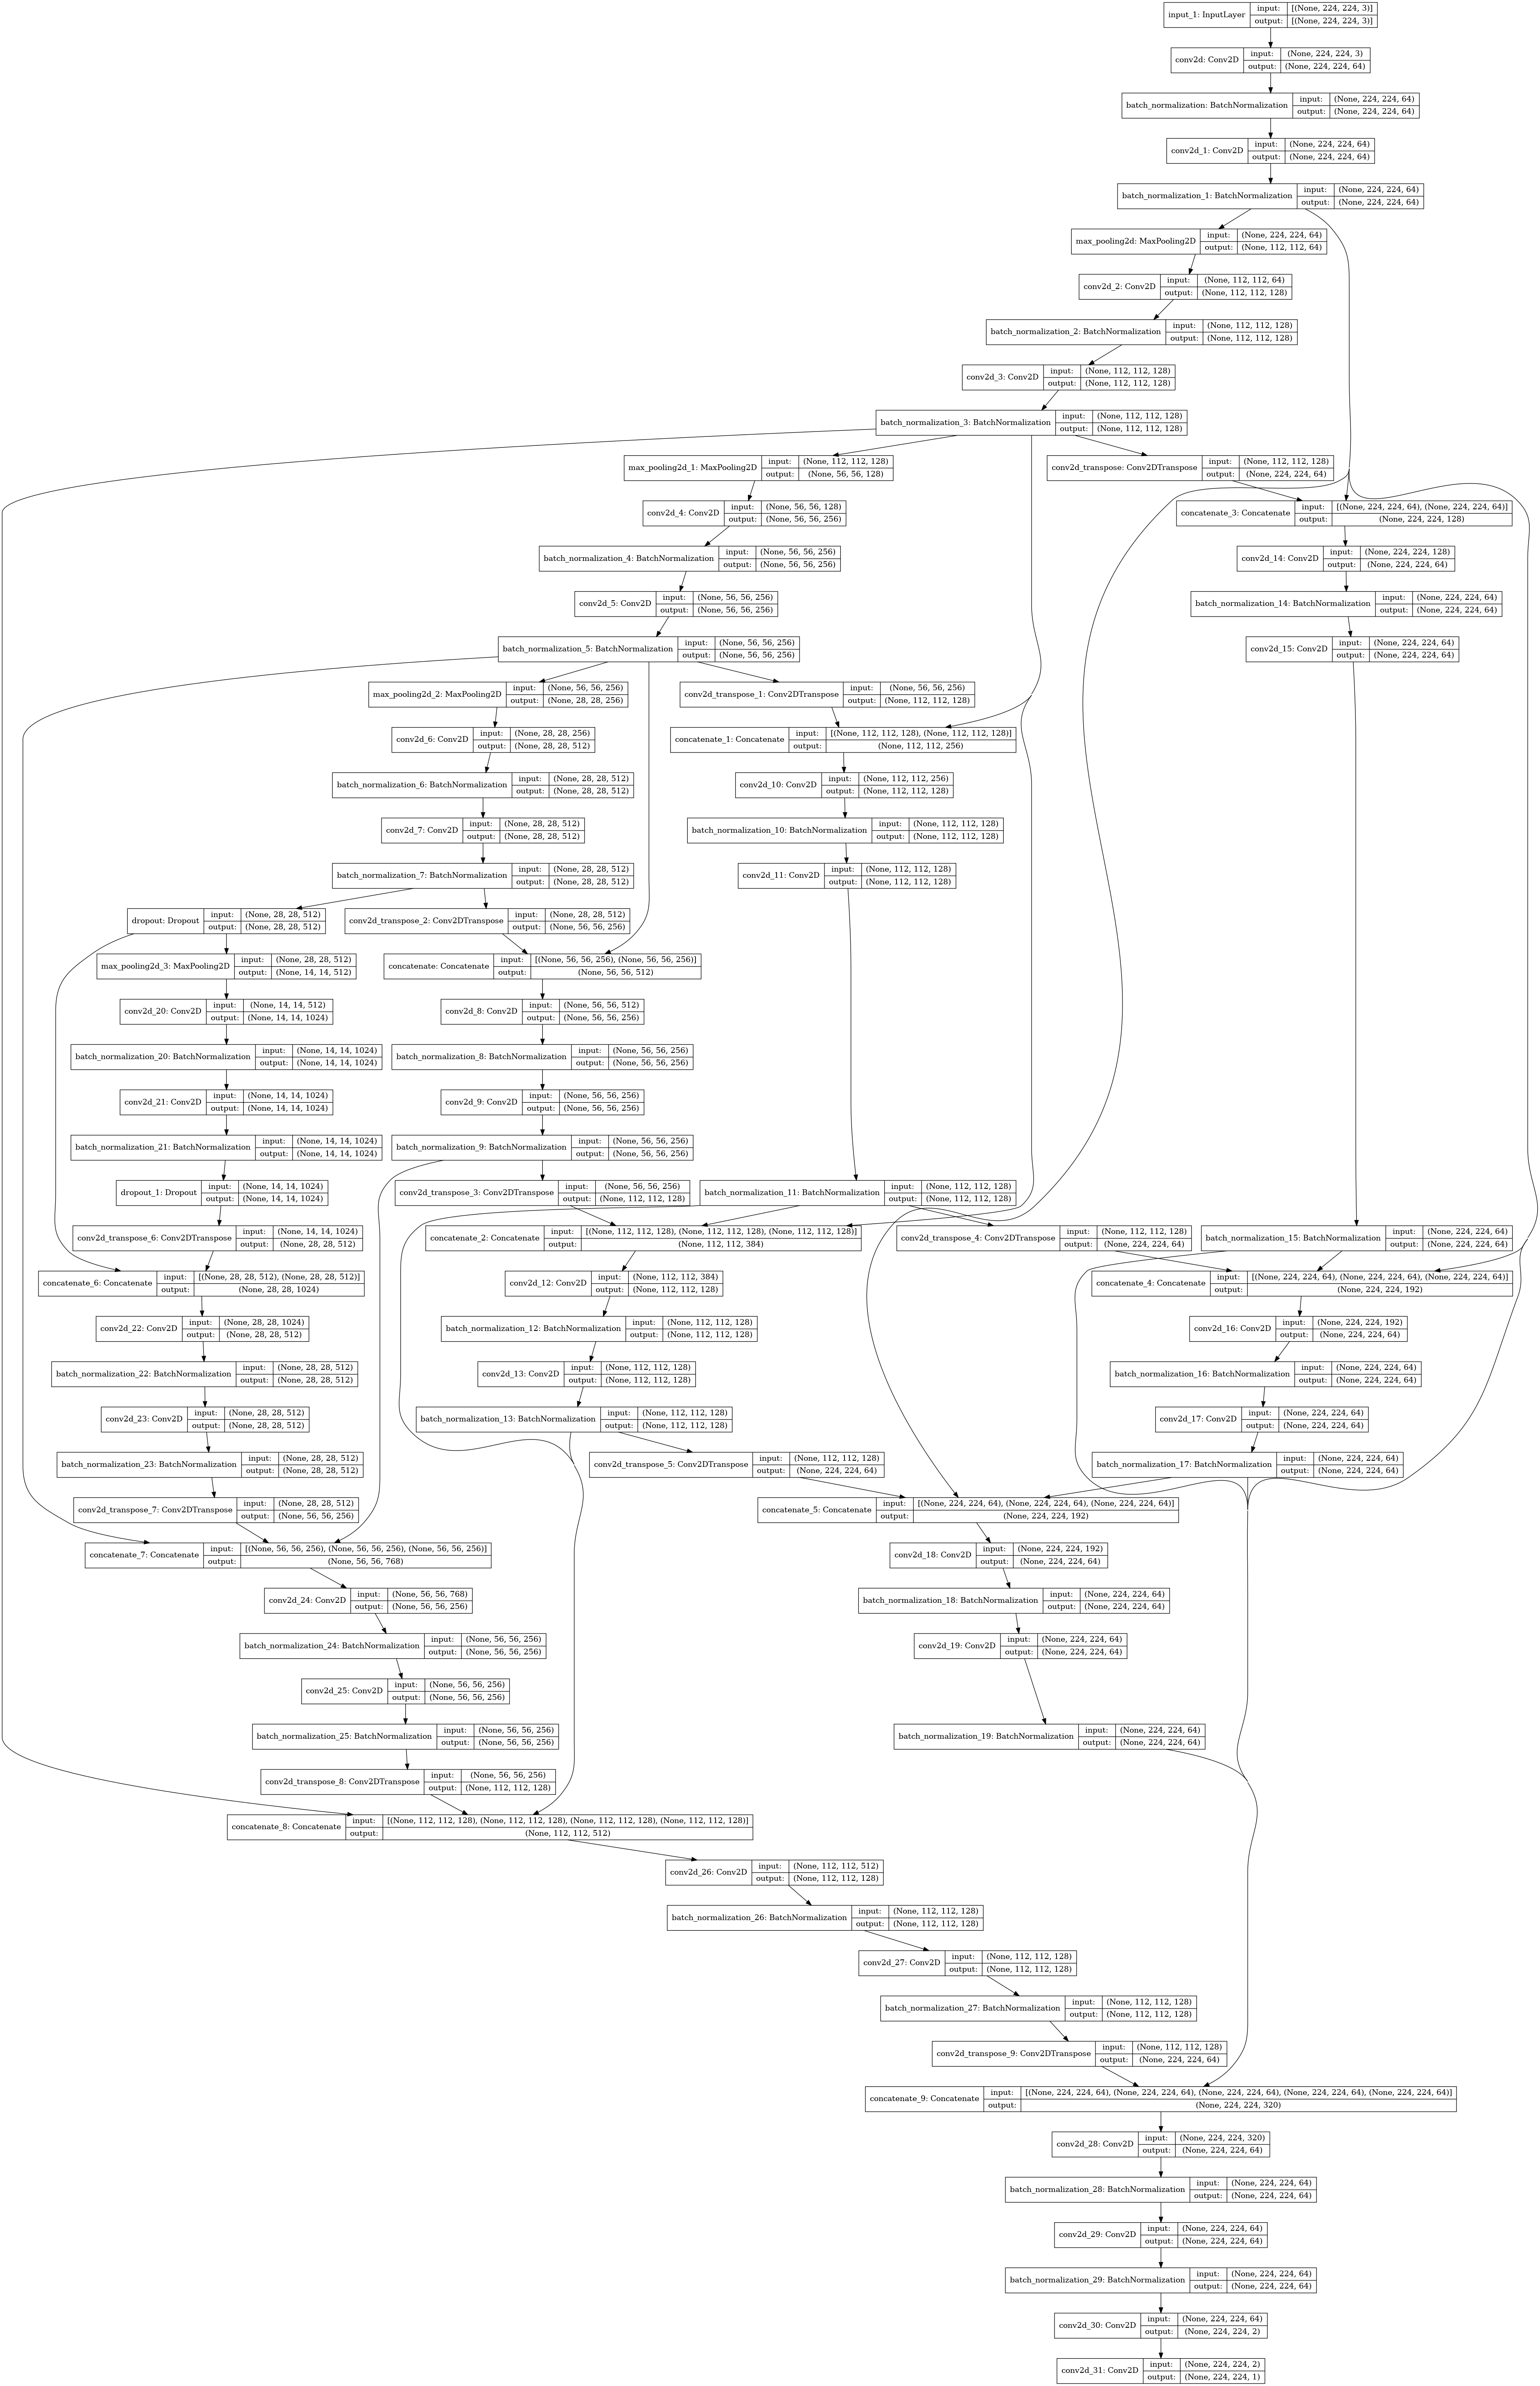

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file = 'a.png', show_shapes = True)

### unet++학습결과

In [14]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output 

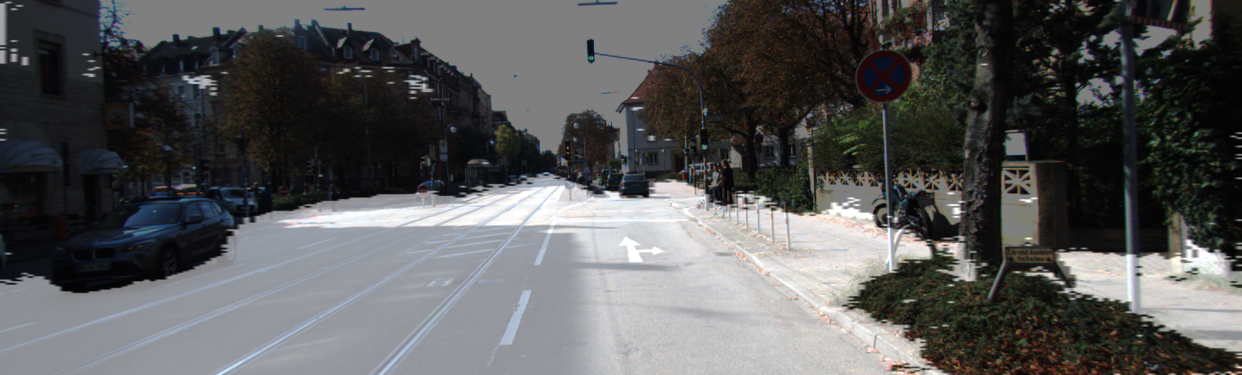

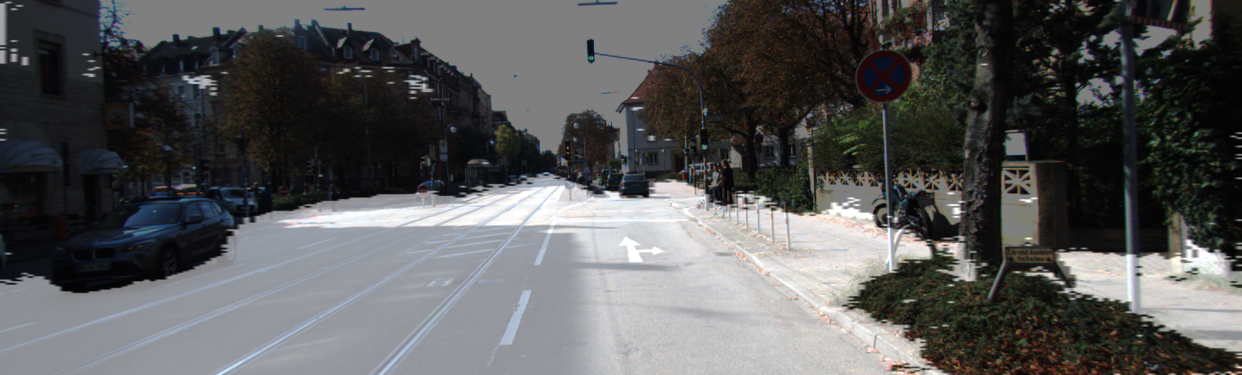

In [15]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [16]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [17]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

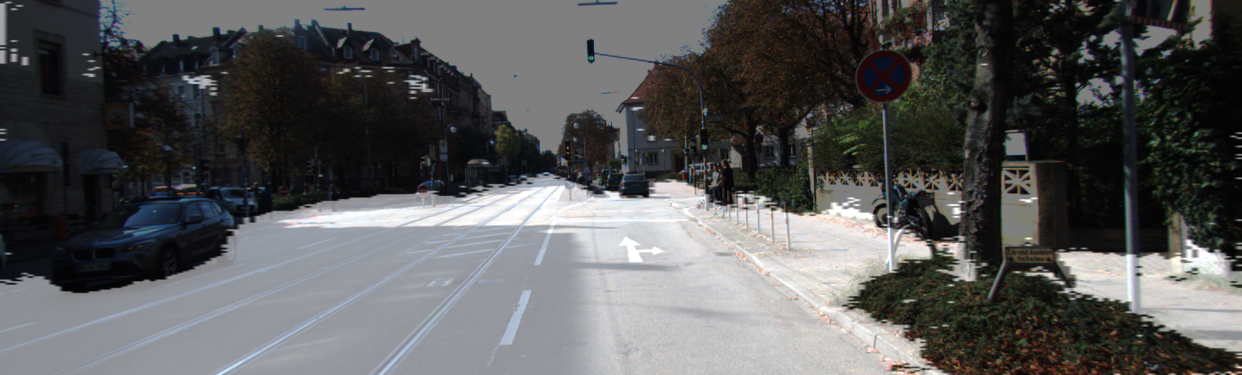

IoU : 0.744244


0.7442440066460955

In [21]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png',
    
 )

calculate_iou_score(target, prediction)

### unet 학습결과.

In [5]:
model_path = dir_path + '/seg_model_unet.h5' 

model = tf.keras.models.load_model(model_path)

In [6]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output 

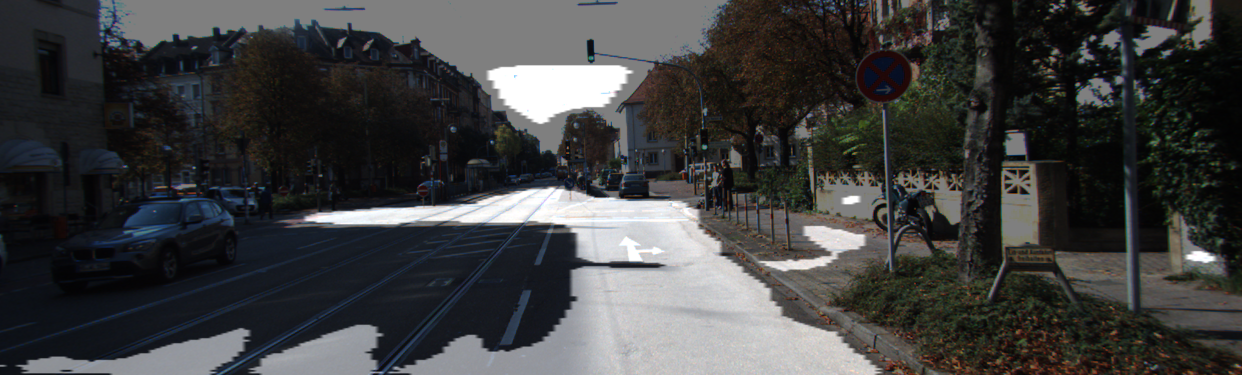

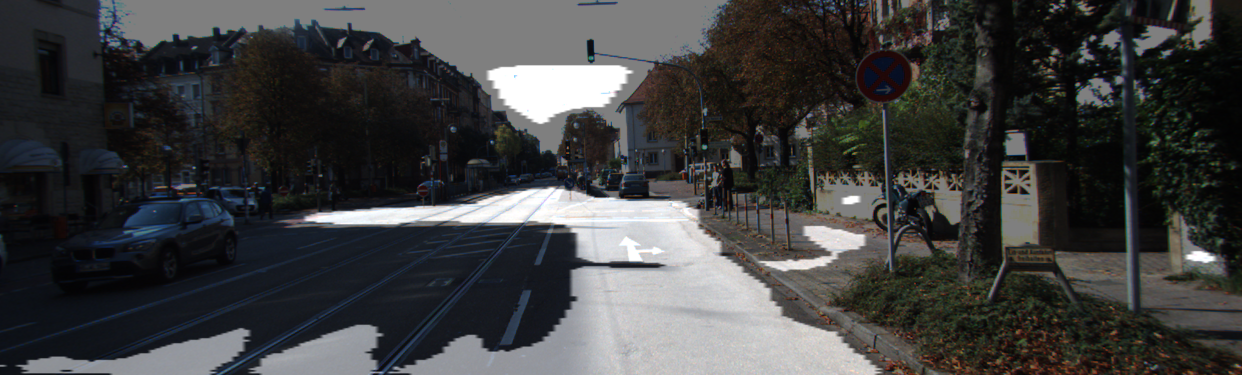

In [14]:
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [15]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [16]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

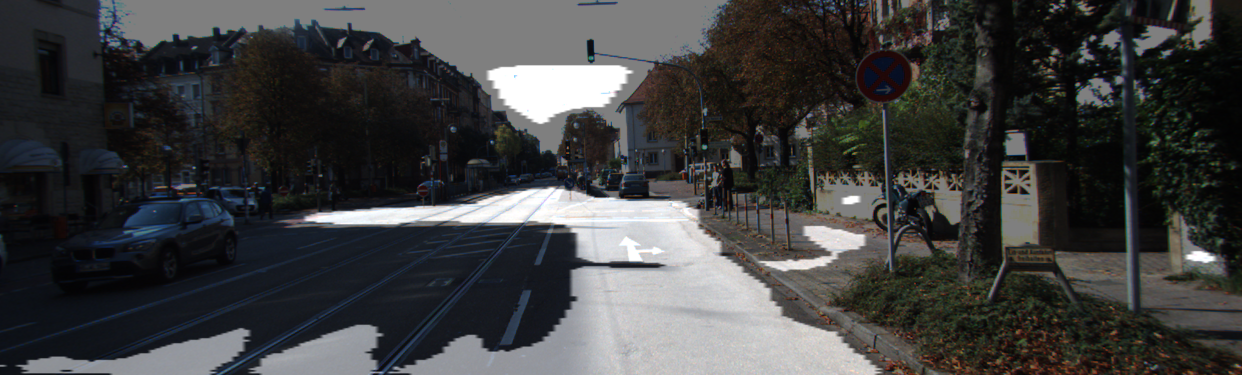

IoU : 0.419641


0.41964089410040306

In [17]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

### lms에서 기본적인 unet모델은 점수가 0.4정도 나왔다 그리고 내가만든 unet++은 점수가 0.7정도 나왔다. 성능이 많이 좋아진것같다. 처음에는 내가 만든 모델이 잘 만들어졌나 의구심도 들었지만 점수가 향상된걸 보니 내 모델이 잘 만들어졌다는 생각이 들어 성공했다는 성취감에 기분이 좋았다. 배치사이즈를 16으로 주고싶었지만 메모리가 터져 8로줄수밖에없는게 아쉬웠다. 이것으로 goingdeeper04를 마친다.